# pip

In [ ]:
!git clone https://github.com/sithu31296/semantic-segmentation
%cd semantic-segmentation
%pip install -e .

Cloning into 'semantic-segmentation'...
remote: Enumerating objects: 792, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 792 (delta 11), reused 39 (delta 11), pack-reused 753
Receiving objects: 100% (792/792), 55.00 MiB | 24.30 MiB/s, done.
Resolving deltas: 100% (462/462), done.
/content/semantic-segmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/semantic-segmentation
     |████████████████████████████████| 50 kB 3.0 MB/s 
     |████████████████████████████████| 235 kB 11.1 MB/s 
     |████████████████████████████████| 596 kB 14.0 MB/s 
     |████████████████████████████████| 42 kB 579 kB/s 
     |████████████████████████████████| 51 kB 7.1 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=8314facac0efbaf22a0be2355980a0573c50e5eb9ed37501ff4ab69b28ffd1c7
  Stored in directory: /ro

In [ ]:
!pip install -q torchsummary
!pip install -Uq git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
smp.__version__

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 376 kB 3.6 MB/s 
     |████████████████████████████████| 58 kB 5.9 MB/s 


'0.3.0-dev'

In [ ]:
!pip install -Uq albumentations
!pip install -q opencv-python-headless==4.5.2.52
# !pip install -q albumentations==0.4.6

     |████████████████████████████████| 116 kB 4.7 MB/s 
     |████████████████████████████████| 48.3 MB 1.8 MB/s 
     |████████████████████████████████| 38.2 MB 1.0 MB/s 


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 

import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as F

from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks
import cv2

from pathlib import Path
from tqdm.notebook import tqdm

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
from skimage.io import imread
import numpy as np
import pandas as pd
import re
from pathlib import Path
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from tqdm import tqdm
import random
import cv2
import seaborn as sns
import torch.nn.functional as FF
from torchvision.io import read_image, write_png, write_file,  ImageReadMode
from torchvision.transforms import InterpolationMode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# File

In [ ]:
ROOT = Path("/content")
DIR_IMAGES = ROOT / "images"
DIR_MASKS = ROOT / "masks"

DIR_PREDS = ROOT / 'preds'
DIR_PREDS.mkdir(exist_ok=True)
pred_transform = A.Compose([
                        A.Resize(height=512,width=1024),
                        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
                        ToTensorV2(),
                        ])
DIR_GPASS = Path('/content/drive/MyDrive/gpass')
DIR_ZIP = DIR_GPASS / 'gpass_test'
DIR_TESTS =  ROOT / 'test_dataset_rzd'

DIR_HOME = Path('/content/drive/MyDrive/gpass')
DIR_MODEL = DIR_HOME / 'model_gpass'

DIR_VAL = ROOT / 'val'

In [ ]:
l_df_train = 'df_train.csv'
l_df_test = 'df_test.csv'
r_df_train = DIR_GPASS / l_df_train
r_df_test  = DIR_GPASS / l_df_test
if not Path(l_df_train).exists():
    !cp $r_df_train .
if not Path(l_df_test).exists():
    !cp $r_df_test .   
df_train = pd.read_csv(l_df_train)
df_test  = pd.read_csv(l_df_test)

In [ ]:
a, b = 450*16, 464*16
X_train = df_train['name'][:a].values
X_val   = df_train['name'][a:].values
df_val = df_train[a:]
# X_test  = df_train['name'][b:].values

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
# print('Test Size    : ', len(X_test))

Train Size   :  7200
Val Size     :  1003


# def

In [ ]:
from zipfile import ZipFile
def unzip_file(ipath, opath = None):
    # Open your .zip file
    with ZipFile(file = ipath) as zip_file:
        # Loop over each file
        iname = ipath.name
        for file in tqdm(iterable=zip_file.namelist(), desc = iname, total=len(zip_file.namelist())):
            # Extract each file to another directory
            # If you want to extract to current working directory, don't specify path
            expath = (Path(opath) / file)
            if not expath.exists():
                zip_file.extract(member=file, path=opath)

In [ ]:
def predict_image(model, image,  mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([ToTensorV2(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0).numpy()
    return masked

In [ ]:
def get_mask(mask):
    obj_ids = torch.unique(mask)
    # first id is the background, so remove it.
    obj_ids = obj_ids[1:]
    masks = []
    for num in obj_ids:
        # _ = np.expand_dims(mask[0] == num, axis=0)
        # masks.append(_)
        masks.append(mask[0] == num)
    masks = np.stack(masks)
    masks = torch.tensor(masks)
    return masks

In [ ]:
def hex_to_rgb(hex_string):
    r_hex = hex_string[1:3]
    g_hex = hex_string[3:5]
    b_hex = hex_string[5:7]
    return int(r_hex, 16), int(g_hex, 16), int(b_hex, 16)


In [ ]:
import torch
from torchvision import io
from torchvision import transforms as T
from PIL import Image

def show_image(image):
    if image.shape[2] != 3: image = image.permute(1, 2, 0)
    image = Image.fromarray(image.numpy())
    return image

In [ ]:
list_zips = sorted(DIR_ZIP.glob("*.zip"))
for zfile in list_zips:
    unzip_file(zfile, opath = '/content')

test_dataset_rzd.zip: 100%|██████████| 1001/1001 [01:06<00:00, 15.09it/s]


In [ ]:
DIR_ZIP = DIR_HOME / 'dataset_ainol'
DIR_ZIP = DIR_HOME / 'dataset_mk808'
list_zips = sorted(DIR_ZIP.glob("*.zip"))
for zfile in list_zips:
    unzip_file(zfile, opath = '/content')

1024_1920_9.zip: 100%|██████████| 406/406 [00:04<00:00, 99.48it/s] 


# Start

In [ ]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DDRNet39

In [ ]:
'''
DDRNet39
'''

import math
import torch
import numpy as np 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from collections import OrderedDict

# BatchNorm2d = nn.SyncBatchNorm
BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion,
                               momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes):
        super(DAPPM, self).__init__()
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm2d(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm2d(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm2d(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm2d(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )        
        self.compression = nn.Sequential(
                                    BatchNorm2d(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):

        #x = self.downsample(x)
        width = x.shape[-1]
        height = x.shape[-2]        
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear')+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear')+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear')+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear')+x_list[3])))
       
        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out 

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):
        
        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear')

        return out

class DualResNet(nn.Module):

    def __init__(self, block, layers, num_classes=19, planes=64, spp_planes=128, head_planes=128, augment=False):
        super(DualResNet, self).__init__()

        highres_planes = planes * 2
        self.augment = augment

        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=False)
        self.layer1 = self._make_layer(block, planes, planes, layers[0])
        self.layer2 = self._make_layer(block, planes, planes * 2, layers[1], stride=2)
        self.layer3_1 = self._make_layer(block, planes * 2, planes * 4, layers[2] // 2, stride=2)
        self.layer3_2 = self._make_layer(block, planes * 4, planes * 4, layers[2] // 2)
        self.layer4 = self._make_layer(block, planes * 4, planes * 8, layers[3], stride=2)

        self.compression3_1 = nn.Sequential(
                                          nn.Conv2d(planes * 4, highres_planes, kernel_size=1, bias=False),
                                          BatchNorm2d(highres_planes, momentum=bn_mom),
                                          )

        self.compression3_2 = nn.Sequential(
                                          nn.Conv2d(planes * 4, highres_planes, kernel_size=1, bias=False),
                                          BatchNorm2d(highres_planes, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, highres_planes, kernel_size=1, bias=False),
                                          BatchNorm2d(highres_planes, momentum=bn_mom),
                                          )

        self.down3_1 = nn.Sequential(
                                   nn.Conv2d(highres_planes, planes * 4, kernel_size=3, stride=2, padding=1, bias=False),
                                   BatchNorm2d(planes * 4, momentum=bn_mom),
                                   )

        self.down3_2 = nn.Sequential(
                                   nn.Conv2d(highres_planes, planes * 4, kernel_size=3, stride=2, padding=1, bias=False),
                                   BatchNorm2d(planes * 4, momentum=bn_mom),
                                   )

        self.down4 = nn.Sequential(
                                   nn.Conv2d(highres_planes, planes * 4, kernel_size=3, stride=2, padding=1, bias=False),
                                   BatchNorm2d(planes * 4, momentum=bn_mom),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(planes * 4, planes * 8, kernel_size=3, stride=2, padding=1, bias=False),
                                   BatchNorm2d(planes * 8, momentum=bn_mom),
                                   )

        self.layer3_1_ = self._make_layer(block, planes * 2, highres_planes, layers[2] // 2)

        self.layer3_2_ = self._make_layer(block, highres_planes, highres_planes, layers[2] // 2)

        self.layer4_ = self._make_layer(block, highres_planes, highres_planes, layers[3])

        self.layer5_ = self._make_layer(Bottleneck, highres_planes, highres_planes, 1)

        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 1, stride=2)

        self.spp = DAPPM(planes * 16, spp_planes, planes * 4)

        if self.augment:
            self.seghead_extra = segmenthead(highres_planes, head_planes, num_classes)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)


    def forward(self, x):
        B, C, H, W = x.shape
        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8
        layers = []

        x = self.conv1(x)

        x = self.layer1(x)
        layers.append(x)

        x = self.layer2(self.relu(x))
        layers.append(x)
  
        x = self.layer3_1(self.relu(x))
        layers.append(x)
        x_ = self.layer3_1_(self.relu(layers[1]))
        x = x + self.down3_1(self.relu(x_))
        x_ = x_ + F.interpolate(
                        self.compression3_1(self.relu(layers[2])),
                        size=[height_output, width_output],
                        mode='bilinear')

        x = self.layer3_2(self.relu(x))
        layers.append(x)
        x_ = self.layer3_2_(self.relu(x_))
        x = x + self.down3_2(self.relu(x_))
        x_ = x_ + F.interpolate(
                        self.compression3_2(self.relu(layers[3])),
                        size=[height_output, width_output],
                        mode='bilinear')

        temp = x_

        x = self.layer4(self.relu(x))
        layers.append(x)
        x_ = self.layer4_(self.relu(x_))
        x = x + self.down4(self.relu(x_))
        x_ = x_ + F.interpolate(
                        self.compression4(self.relu(layers[4])),
                        size=[height_output, width_output],
                        mode='bilinear')

        x_ = self.layer5_(self.relu(x_))
        x = F.interpolate(
                        self.spp(self.layer5(self.relu(x))),
                        size=[height_output, width_output],
                        mode='bilinear')

        x_ = self.final_layer(x + x_)

        x_ = F.interpolate(x_, size=[H, W], mode='bilinear')

        if self.augment: 
            x_extra = self.seghead_extra(temp)
            return [x_, x_extra]
        else:
            return x_      

def DDRNet(pretrained=True, num_classes=19):
    model = DualResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, planes=64, spp_planes=128, head_planes=256, augment=False)
    if pretrained:
        checkpoint = torch.load('./DDRNet/DDRNet39_imagenet.pth', map_location='cpu')
        model.load_state_dict(checkpoint, strict = False)
    return model


def get_seg_model(**kwargs):

    model = DDRNet(pretrained=True, num_classes=11)
    return model






# Start

In [ ]:
palette = list(sns.color_palette("tab10", 11).as_hex())
palette[6] = '#b4af1f'
palette[7] = '#1fb45b' # синий
palette[10] = '#291fb4'


In [ ]:
def see_preds():
    list_dir = sorted(os.listdir(DIR_VAL))
    ii = random.randrange(0, len(list_dir) )

    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))
    _file = list_dir[ii]

    file_img  = DIR_IMAGES  / _file
    file_mask = DIR_MASKS / _file
    file_val  = DIR_VAL / _file

    img = cv2.imread(str(file_img), 1 )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    toresize=(1024, 512)

    img = cv2.resize(img, toresize )
    mask = imread(file_mask, 0)
    mask = cv2.resize(mask, toresize, interpolation=cv2.INTER_NEAREST )
    
    m_val = imread(file_val, 0)
    m_val = cv2.resize(m_val, toresize, interpolation=cv2.INTER_NEAREST )

    # _resiz = img.shape[:2]
    # img = FF.interpolate(img, size=(128,256), mode='nearest-exact' )

    num_mask = np.unique(m_val)
    color = (255, 0, 0)
    for ch in num_mask[1:]:
        # mask = np.where(mask == ch, 0, 255)
        contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, hex_to_rgb(palette[ch]), 2)


    axs[0].imshow(img)
    axs[0].imshow(mask, alpha=0.5)
    axs[0].axis('off')

    axs[1].imshow(img)
    axs[1].imshow(m_val, alpha=0.5)
    axs[1].axis('off')
    plt.show()

In [ ]:
def see_preds2(false = 0, ncols=2):
    list_dir = sorted(os.listdir(DIR_VAL))
    nrows = len(list_dir)//2
    fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(20, nrows*8))
    axs = axs.ravel()

    for ii, _file in enumerate(list_dir[:24]):

        file_img  = DIR_IMAGES  / _file
        file_mask = DIR_MASKS / _file
        file_val  = DIR_VAL / _file

        img = cv2.imread(str(file_img), 1 )
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        toresize=(1024, 512)

        img = cv2.resize(img, toresize )
        mask = imread(file_mask, 0)
        mask = cv2.resize(mask, toresize, interpolation=cv2.INTER_NEAREST )

        m_val = imread(file_val, 0)
        m_val = cv2.resize(m_val, toresize, interpolation=cv2.INTER_NEAREST )

        if false > 0:
            m_val  = np.where(m_val > 3, m_val, 0)

        num_mask = np.unique(mask)
        # print(num_mask)
        color = (255, 0, 0)
        for ch in num_mask[1:]:
            contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            for i in range(0, len(contours)):
                cv2.polylines(img, contours[i], True, hex_to_rgb(palette[ch]), 5)

        axs[ii].imshow(img)
        axs[ii].imshow(m_val, alpha=0.6)
        axs[ii].set_title(_file)
        axs[ii].axis('off')


In [ ]:
import torch
from torch import Tensor
from typing import Tuple

class Metrics:
    def __init__(self, num_classes: int, ignore_label: int, device) -> None:
        self.ignore_label = ignore_label
        self.num_classes = num_classes
        self.hist = torch.zeros(num_classes, num_classes).to(device)

    def update(self, pred: Tensor, target: Tensor) -> None:
        pred = pred.argmax(dim=1)
        keep = target != self.ignore_label
        self.hist += torch.bincount(target[keep] * self.num_classes + pred[keep], minlength=self.num_classes**2).view(self.num_classes, self.num_classes)

    def compute_iou(self) -> Tuple[Tensor, Tensor]:
        ious = self.hist.diag() / (self.hist.sum(0) + self.hist.sum(1) - self.hist.diag())
        miou = ious[~ious.isnan()].mean().item()
        ious *= 100
        miou *= 100
        return ious.cpu().numpy().round(2).tolist(), round(miou, 2)

    def compute_f1(self) -> Tuple[Tensor, Tensor]:
        f1 = 2 * self.hist.diag() / (self.hist.sum(0) + self.hist.sum(1))
        mf1 = f1[~f1.isnan()].mean().item()
        f1 *= 100
        mf1 *= 100
        return f1.cpu().numpy().round(2).tolist(), round(mf1, 2)

    def compute_pixel_acc(self) -> Tuple[Tensor, Tensor]:
        acc = self.hist.diag() / self.hist.sum(1)
        macc = acc[~acc.isnan()].mean().item()
        acc *= 100
        macc *= 100
        return acc.cpu().numpy().round(2).tolist(), round(macc, 2)



In [ ]:
def see_num_pred(num=125):
    _file = X_val[num]
    DIR_IMAGES = ROOT / "images"
    DIR_MASKS = ROOT / "masks"

    file_img  = str(DIR_IMAGES  / _file)
    file_mask = str(DIR_MASKS / _file)
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))
    palette = list(sns.color_palette("tab10", 11).as_hex())

    img = cv2.imread(str(file_img), 1 )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    toresize=(1024, 512)
    img = cv2.resize(img, toresize )
    mask = imread(file_mask, 0)
    mask = cv2.resize(mask, toresize, interpolation=cv2.INTER_NEAREST )

    image = t(img)
    model.to(device); image=image.to(device)
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0)
        output = model(image)
        masked = torch.argmax(output, dim=1)
        pred = masked.cpu().squeeze(0)
        predn = pred.numpy().astype(np.uint8)
    
    num_mask = np.unique(predn)
    color = (255, 0, 0)
    for ch in num_mask[1:]:
        # mask = np.where(mask == ch, 0, 255)
        contours, _ = cv2.findContours(predn, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, hex_to_rgb(palette[ch]), 2)

    axs[0].imshow(img)
    axs[0].imshow(mask, alpha=0.6)
    axs[1].imshow(img)
    axs[1].imshow(predn, alpha=0.6)

    return pred, mask

In [ ]:
size_image =(512,1024)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
t = T.Compose([T.ToTensor(),
                T.Resize(size_image), 
                T.Normalize(mean, std)])

# model_weights

In [ ]:
list_models = sorted(list(DIR_MODEL.glob('DDRNet39g*.ckpt')))
model_weights =list_models[1]


# Model Start

In [ ]:
class CustomModel(nn.Module):
    def __init__(self,  model =None):
        super().__init__()
        self.model = model
    def forward(self, x):
        out = self.model(x)
        return out

In [ ]:
def_model = DDRNet(pretrained=False, num_classes=11)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
state = torch.load(model_weights, map_location=torch.device(device))


In [ ]:
model = CustomModel(model = def_model)
model.load_state_dict(state['state_dict'], strict = False)

<All keys matched successfully>

# Validation

In [ ]:
from torchvision.utils import save_image
from torchvision.io import read_image, write_png, write_file,  ImageReadMode

!rm -rf $DIR_VAL
DIR_VAL.mkdir(exist_ok=True)

_out_1 ={}
_out_2 ={}
_out_11 =[]
_out_22 =[]

model.eval()
df = df_val.sample(n=24)

for idx, row in tqdm(df.iterrows(), total=len(df)):
    h=row['h']
    w=row['w']
    name = row['name']
    image = cv2.imread(str(DIR_IMAGES / name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(str(DIR_MASKS / name), 0)
    transformed = pred_transform(image=image, mask=mask)
    image  = transformed["image"]
    labels = transformed["mask"].unsqueeze(0)

    model.to(device); image=image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        logits_mask = model(image)
        pred_mask = torch.argmax(FF.softmax(logits_mask, dim=1), dim=1)
        error = 0
        error = pred_mask[pred_mask > 3].sum()

        pred_mask = torch.where(pred_mask > 3, 0, pred_mask)  # Кинуть в 7 класс
        pred_mask = torch.where(pred_mask == 1, 6, pred_mask)
        pred_mask = torch.where(pred_mask == 2, 7, pred_mask)
        pred_mask = torch.where(pred_mask == 3, 10, pred_mask)

    _torig = T.Compose([
                        T.Resize((h, w), interpolation=T.InterpolationMode.NEAREST),
                       ])

    img_pred = _torig(pred_mask).type(torch.uint8).cpu()
    write_png(img_pred, str(DIR_VAL / name), compression_level=1)


100%|██████████| 24/24 [00:04<00:00,  5.73it/s]


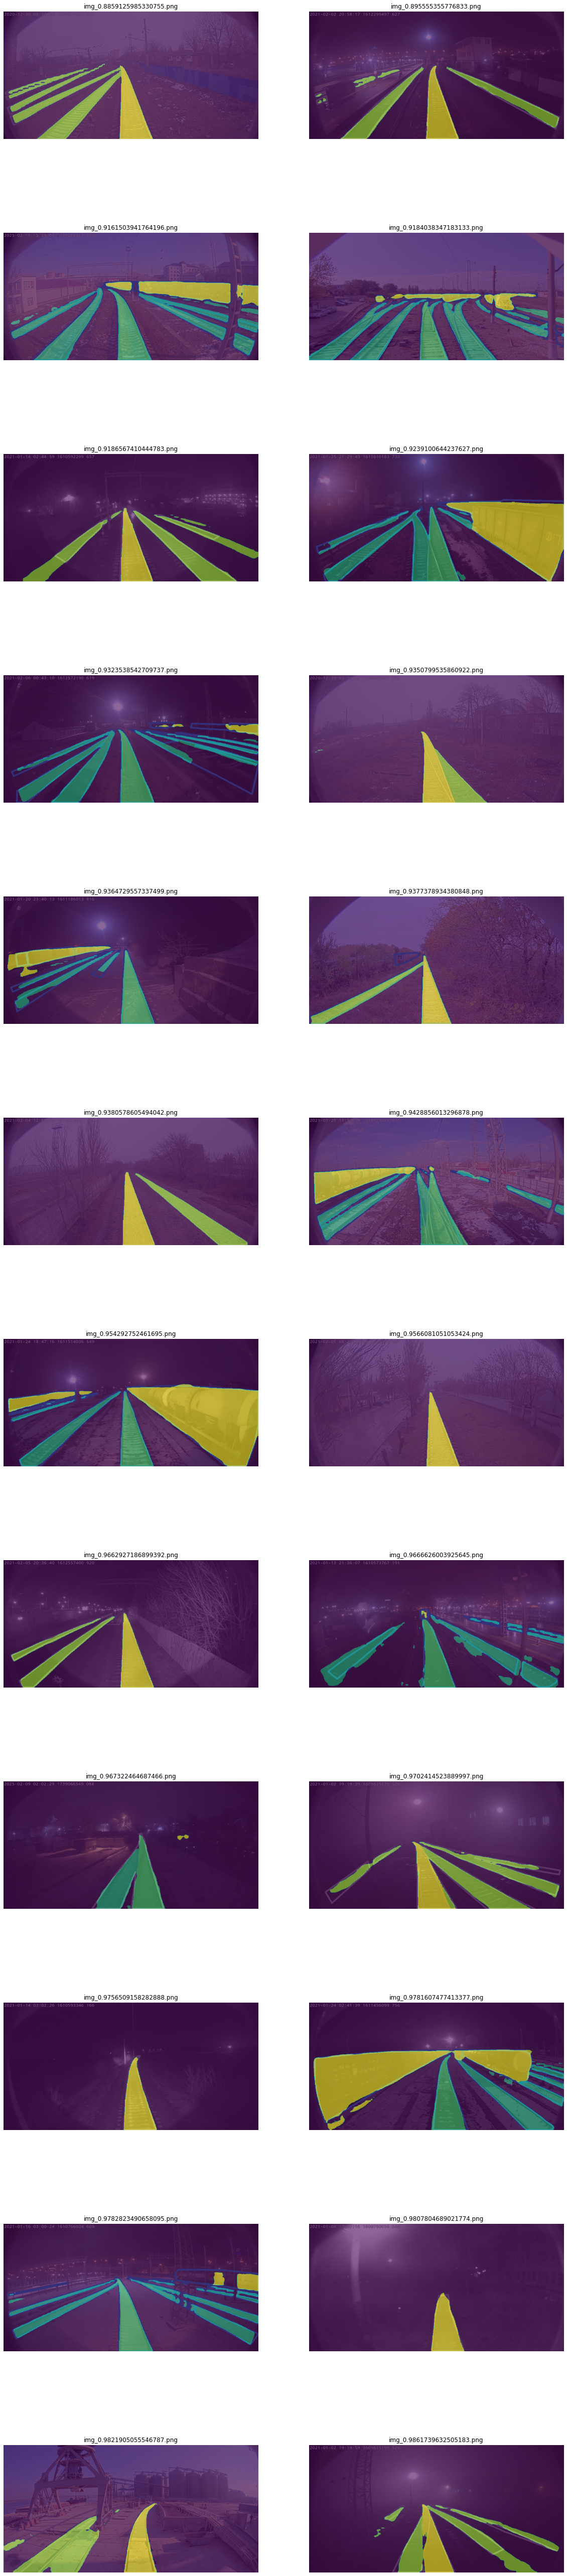

In [ ]:
see_preds2()

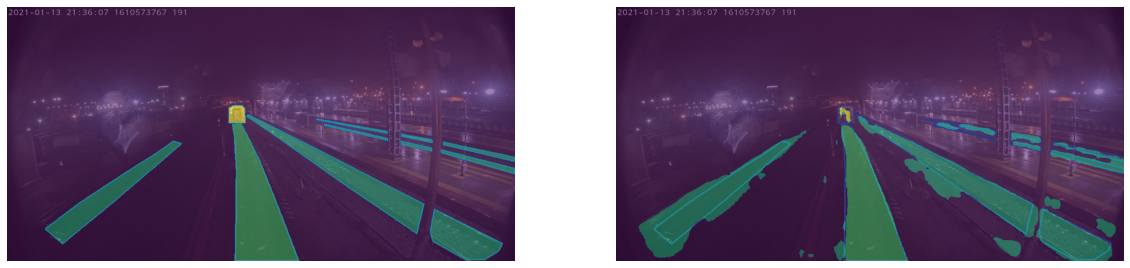

In [ ]:
plt.rcParams["figure.figsize"] = (20,8)
see_preds()

In [ ]:
sdsd

# PPred2

In [ ]:
from torchvision.utils import save_image
# DIR_PREDS_ORIG = ROOT / 'preds_orig'
!rm -rf $DIR_PREDS

DIR_PREDS.mkdir(exist_ok=True)
from torchvision.utils import save_image
from torchvision.io import read_image, write_png, write_file,  ImageReadMode


model.eval()
df = df_test
for idx, row in tqdm(df.iterrows(), total=len(df)):
    h=row['h']
    w=row['w']
    name = row['name']
    image = cv2.imread(str(DIR_TESTS / name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        logits_mask = model(image)
        pred_mask = torch.argmax(FF.softmax(logits_mask, dim=1), dim=1)
        error = 0
        error = pred_mask[pred_mask > 3].sum()

        pred_mask = torch.where(pred_mask > 3, 7, pred_mask)  # Кинуть в 7 класс
        pred_mask = torch.where(pred_mask == 1, 6, pred_mask)
        pred_mask = torch.where(pred_mask == 2, 7, pred_mask) 
        pred_mask = torch.where(pred_mask == 3, 10, pred_mask) 

    _torig = T.Compose([
                        T.Resize((h, w), interpolation=T.InterpolationMode.NEAREST),
                         ])

    img_pred = _torig(pred_mask).type(torch.uint8).cpu()
    write_png(img_pred, str(DIR_PREDS / name), compression_level=1)




100%|██████████| 1000/1000 [06:08<00:00,  2.71it/s]


In [ ]:
from os.path import basename
with ZipFile(ROOT / 'out_20220720_DDRNet39_36_951_.zip', 'w') as myzip:
    for file in tqdm(DIR_PREDS.iterdir()):
        myzip.write(file, basename(file))

1000it [00:00, 5722.79it/s]


In [ ]:
plt.rcParams["figure.figsize"] = (20,8)
see_preds()

In [ ]:
torch.save(model.state_dict(), DIR_GPASS / 'model'/ 'out_DDRNet39_512_124_36_951.pth' )